# **Automate extraction of handwritten text from an image**



---



---


**Name Of The Student		:**	Neeraj V B

**Internship Project Title		:** Automate extraction of handwritten text from an image

**Name of the Company	:** TCS iON

**Name of the Industry Mentor	:** Debashis Roy

**Name of the Institute		:** ICT Academy of Kerala


---



---




## **Introduction**
This project aims to develop machine learning algorithms in order to enable entity and knowledge extraction from documents with handwritten annotations, with an aim to identify handwritten words on an image.
When it comes to addressing the challenge of sequence recognition, recurrent neural networks (RNNs) prove to be highly suitable.On the other hand, convolutional neural networks (CNNs) excel in image-related tasks. However, for Optical Character Recognition (OCR) problems like the one at hand, a combination of both CNN and RNN becomes imperative. By leveraging the strengths of both networks, we can effectively tackle the intricacies of handwritten word identification within images.

We can break the implementation of CRNN network into following steps:

1.   Selecting Dataset
2.   Pre-processing Data
3.   Splitting the Data
4.   Building Model Architecture
6.   Model Training
7.   Model Evaluation
8.   Exporting the Model

## **Selecting Dataset**
I downloaded the words.tgz from the [IAM handwritten datset](https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database). This is a large image dataset total of 115320 images with a size of 1.09 GB. I also downloaded the ascii.tgz part of the dataset which contains words.txt containing information about the written words. I uploaded both words.tgz and words.txt to my google drive.

Out of the total images, 96456 images are labelled as 'ok' by the ascii representation, others have errors. I random sampled 90000 images from this to serve as the training + validation dataset and the remaining 6456 images to serve as testing dataset. I uploaded them both to my google drive for easier access

*The below cells are commented because it does not need to be run again as dataset is already created and uploaded to my google drive*

**Extracted words.tgz and read all available images to a list**

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')

!mkdir words_temp
!mkdir words
!mkdir words_test
!cp "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/words.tgz" "words.tgz"
!cp "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/words.txt" "words.txt"

!tar -xzf words.tgz -C words_temp

import os
import shutil

image_file_list = []
for root, directories, files in os.walk('words_temp'):
    for filename in files:
        file_path = os.path.join(root, filename)
        image_file_list.append(file_path)'''

**Read the contents of words.txt and appended all the valid images to a list**

In [ ]:
'''with open('words.txt') as f:
    contents = f.readlines()
f.close()

def clean(text):
    temp = text.rstrip("\n").split(' ')
    return temp[0] + ' ' + " ".join(temp[8:])

valid_file_list = [clean(f).split(' ')[0] for f in contents[18:] if f.split(' ')[1] == 'ok']'''

**Random sampled 90000 images as main dataset and the remaining 6456 images as testing dataset and uploaded both to my gdrive as a zip files**

In [ ]:
'''import random

sample_size = 90000  # Adjust this to the number of items you want to sample

sampled_valid_files = random.sample(valid_file_list, sample_size)
main_files = [item for item in image_file_list if item.rstrip('.png').split('/')[-1] in sampled_valid_files]
test_files = [item for item in image_file_list if (item.rstrip('.png').split('/')[-1] in valid_file_list and not in sampled_valid_files)]

for file_ in main_files:
    dest = file_.split('/')[-1]
    shutil.copy(file_, 'words/')

for file_ in test_files:
    dest = file_.split('/')[-1]
    shutil.copy(file_, 'words_test/')

!zip -r 'words.zip' words
!zip -r 'words_test.zip' words_test
!cp "words.zip" "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/words.zip
!cp "words_test.zip" "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/words_test.zip"'''

**Loading and Extracting the datasets and words.txt from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/words.zip" "words.zip"
!cp "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/words_test.zip" "words_test.zip"
!cp "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/words.txt" "words.txt"
!unzip 'words.zip'
!unzip 'words_test.zip'

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#reading all contents from words.txt that contains the filename and other information about each image
with open('words.txt') as f:
    contents = f.readlines()
f.close()

# function to return only the filename and label seperated by a space from each line
def clean(text):
    temp = text.rstrip("\n").split(' ')
    return temp[0] + ' ' + " ".join(temp[8:])

# reading filenames from the folders in the unzipped zipfile
img_files_main = [f.split('.png')[0] for f in os.listdir('words')]
img_files_test = [f.split('.png')[0] for f in os.listdir('words_test')]

# making a list of filename <space> word for all images labelled as ok
all_valid_images = [clean(f) for f in contents[18:] if f.split(' ')[1] == 'ok']

# seperating them to main and testing data based on the images folder
valid_images_main = [item for item in all_valid_images if item.split(' ')[0] in img_files_main]
valid_images_test = [item for item in all_valid_images if item.split(' ')[0] in img_files_test]

In [ ]:
print("5 samples from main dataset :", valid_images_main[:5])
print("5 samples from testing dataset :", valid_images_test[:5])

5 samples from main dataset : ['a01-000u-00-00 A', 'a01-000u-00-01 MOVE', 'a01-000u-00-02 to', 'a01-000u-00-03 stop', 'a01-000u-00-04 Mr.']
5 samples from testing dataset : ['a01-000u-01-03 Labour', 'a01-000x-02-00 meeting', 'a01-000x-02-07 Michael', 'a01-000x-04-08 Will', 'a01-003-03-06 Labour']


In [ ]:
print(f"Size of training + validation dataset : {len(valid_images_main)} images")
print(f"Size of testing dataset : {len(valid_images_test)} images")

Size of training + validation dataset : 90000 images
Size of testing dataset : 6456 images


**Making a character list of all possible characters from every word excluding blank space**

In [ ]:
words = [' '.join(itm.split(' ')[1:]) for itm in all_valid_images]

char_set = set()
for word in words:
    for char in word:
        char_set.add(char)

char_set.remove(' ')
char_list = sorted(list(char_set))

print("Total number of unique characters:", len(char_list))

Total number of unique characters: 78


## **Pre-processing Data**

To preprocess the input images:

The image is read using opencv as a gray-scale and passed into a function that does the following:
1. Resize the image to a shape (32, 128), i.e 128 pixels wide and 32 pixels high
2. Expand image dimension as (32, 128, 1) to make it compatible with the input shape of architecture.
3. Normalize the image pixel values by dividing it with 255.

To preprocess the output labels:
1. Encode each corresponding words(labels) to numeric sequences
2. Compute the maximum length of a word and post-pad with zeroes to make it in a consistent shape

This is done to make it compatible with the output shape of our RNN architecture. Then convert it into a numpy array.

In [ ]:
# function to encode each output word into digits
def encode_to_labels(text):
    encoded = []
    for char in text:
        encoded.append(char_list.index(char))
    return encoded

# for example
print("The word 'Train' encodes to:", encode_to_labels("Train"))

The word 'Train' encodes to: [45, 69, 52, 60, 65]


In [ ]:
# Function to converts image to shape (32, 128, 1) & normalize it
def process_image(img):
    original_height, original_width = img.shape
    source_aspect_ratio = original_width / original_height

    # if image width is smaller, fill the right side with white space
    if source_aspect_ratio < 4:
        new_height = 32
        new_width = int(original_width * new_height / original_height)
        img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
        img = np.concatenate((img, np.full((new_height, 128-new_width), 255)), axis=1)

    # in terms of a longer text, squeeze it into the desired shape
    if source_aspect_ratio > 4:
        new_height = 32
        new_width = 128
        img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

    # just making sure it's in correct shape
    if img.shape != (32,128):
        img = cv2.resize(img, (128,32))

    # adding an extra dimension in the end and normalizing
    img = cv2.subtract(255, img)
    img = np.expand_dims(img, axis=2)
    img = img / 255

    return img

**Main dataset: Reading images, words and encoding**

In [ ]:
all_images, all_labels, label_lengths, original_text, all_input_length = [], [], [], [], []
max_label_length = 0

for line in valid_images_main:
    splits = line.split(' ')
    file_name = splits[0]
    word = ' '.join(splits[1:])

    # reading the image using opencv as a grayscale image
    image = cv2.imread(f'words/{file_name}.png', cv2.IMREAD_GRAYSCALE)
    try:
        # image in the shape of (32,128,1) and its corresponding encoded word as label
        processed_image = process_image(image)
        label = encode_to_labels(word)
    except:
        continue
    all_images.append(processed_image)
    all_labels.append(label)
    all_input_length.append(31)
    label_lengths.append(len(word))
    original_text.append(word)

    # calculating the maximum length of encoded words
    if len(label) > max_label_length:
        max_label_length = len(label)

all_padded_labels = pad_sequences(all_labels, maxlen=max_label_length, padding='post')

**Testing dataset: Reading images, words and encoding**

In [ ]:
test_images, test_labels, test_original_text = [], [], []

for line in valid_images_test:
    splits = line.split(' ')
    file_name = splits[0]
    word = ' '.join(splits[1:])

    # reading the image using opencv as a grayscale image
    image = cv2.imread(f'words_test/{file_name}.png', cv2.IMREAD_GRAYSCALE)
    try:
        # image in the shape of (32,128,1) and its corresponding encoded word as label
        processed_image = process_image(image)
        label = encode_to_labels(word)
    except:
        continue
    if len(label) <= max_label_length:
        test_images.append(processed_image)
        test_labels.append(label)
        test_original_text.append(word)

test_padded_labels = pad_sequences(test_labels, maxlen=max_label_length, padding='post')

## **Splitting the data**
The main dataset is split into training and validation sets with 85% data for training and 15% for validation. They are them converted into numpy arrays in order to be able to be fed into a neural network.

In [ ]:
train_size = 0.85
split_index = int(len(all_images) * train_size)

# training and validation dataset
train_images = np.array(all_images[:split_index])
valid_images = np.array(all_images[split_index:])

train_padded_label = np.array(all_padded_labels[:split_index])
valid_padded_label = np.array(all_padded_labels[split_index:])

train_input_length = np.array(all_input_length[:split_index])
valid_input_length = np.array(all_input_length[split_index:])

train_label_lengths = np.array(label_lengths[:split_index])
valid_label_lengths = np.array(label_lengths[split_index:])

train_original_text = np.array(original_text[:split_index])
valid_original_text = np.array(original_text[split_index:])

# testing dataset
test_images = np.array(test_images)
test_padded_labels = np.array(test_padded_labels)
test_original_text = np.array(test_original_text)

In [ ]:
print("Training data size:", train_padded_label.shape[0])
print("Validation data size:", valid_padded_label.shape[0])
print("Testing data size:", test_padded_labels.shape[0])

Training data size: 76478
Validation data size: 13497
Testing data size: 6453


# **Building Model Architecture**
**Architecture**: Convolutional Recurrent Neural Network(CRNN)

This network architecture is inspired by this [paper](https://arxiv.org/pdf/1507.05717.pdf).
Let's see the steps that we used to create the architecture:

Our images are of height 32 pixels and of width 128 pixels, thus making the architecture's input shape as (32, 128, 1). In this design, we incorporated seven convolutional layers, with six of them employing a kernel size of (3,3), while the last one utilizes a size of (2,2). This progressive arrangement also involves an increase in the number of filters, starting from 64 and gradually reaching 512 as we move through the layers.

To enhance the model's feature extraction capabilities, we introduced two max-pooling layers with dimensions (2,2). Additionally, we included two more max-pooling layers sized (2,1) to capture broader features, a valuable asset for predicting longer texts.

To optimize the training process, we integrated batch normalization layers after the fifth and sixth convolutional layers. This speeds up training and acts as a regularizer.

To accommodate the architecture's structure, we implemented a lambda function to compress the output from the convolutional layers, ensuring compatibility with the subsequent LSTM layer.

Subsequently, we integrated two Bidirectional LSTM layers, each comprised of 128 units. This configuration of Recurrent Neural Network (RNN) components produces an output of dimensions (batch_size, 31, 79). In this context, the number 79 represents the comprehensive count of output classes, including the blank character.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, BatchNormalization, Bidirectional, LSTM, Input, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

In [ ]:
# keras sequential model
crnn_model = Sequential()
crnn_model.add(Input(shape=(32, 128, 1)))

# CNN layers in combination with maxpooling layers
crnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
crnn_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

crnn_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
crnn_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

crnn_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
crnn_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

# batch normalization for faster convergence and regularization
crnn_model.add(MaxPool2D(pool_size=(2, 1)))

crnn_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
crnn_model.add(BatchNormalization())

crnn_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
crnn_model.add(BatchNormalization())
crnn_model.add(MaxPool2D(pool_size=(2, 1)))

crnn_model.add(Conv2D(512, (2, 2), activation='relu'))

# To make it compatible with RNN
crnn_model.add(Lambda(lambda x: K.squeeze(x, 1)))

# RNN layers
crnn_model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.25)))
crnn_model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.25)))

crnn_model.add(Dense(len(char_list) + 1, activation='softmax'))
crnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 32, 256)        5

**Defining CTC loss function**

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_length], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int8')
label_length = Input(name='label_length', shape=[1], dtype='int8')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([crnn_model.output, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[crnn_model.input, the_labels, input_length, label_length], outputs=loss_out)

# **Model Training**

For model training, we will employ the SGD (Stochastic Gradient Descent) optimizer. Additionally, leveraging Keras callbacks functionality, we can save the weights of the top-performing model based on validation accuracy. Notably, in the "model.compile()" step, it's evident that only the predicted outputs (y_pred) were included, while the actual ground truth labels (y_true) were omitted. This choice stems from the fact that the labels were already integrated as input during an earlier stage of model development.

With these preparations in place, you can proceed to train your model using a training dataset comprising 76,478 images and a validation dataset of 13,497 images. This training phase is vital to fine-tune the model's performance and enable it to generalize well to new data.

In [ ]:
batch_size = 32
epochs = 35
optimizer = 'sgd'
weights_file = "weights.hdf5"

x_train = [train_images, train_padded_label, train_input_length, train_label_lengths]
y_train = np.zeros(len(train_images))
x_val = [valid_images, valid_padded_label, valid_input_length, valid_label_lengths]
y_val = np.zeros(len(valid_images))

**Compilation and Callbacks**

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics=['accuracy'])

# callback to save the best model weights to a file by monitoring validation accuracy
checkpoint = ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

**Fitting the model**

In [ ]:
history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1, callbacks=[checkpoint])

Epoch 1/35
2390/2390 [==============================] - ETA: 0s - loss: 12.0628 - accuracy: 0.0352
Epoch 1: val_accuracy improved from -inf to 0.12781, saving model to weights.hdf5
2390/2390 [==============================] - 162s 59ms/step - loss: 12.0628 - accuracy: 0.0352 - val_loss: 8.0761 - val_accuracy: 0.1278
Epoch 2/35
2389/2390 [============================>.] - ETA: 0s - loss: 5.7471 - accuracy: 0.2044
Epoch 2: val_accuracy improved from 0.12781 to 0.27021, saving model to weights.hdf5
2390/2390 [==============================] - 143s 60ms/step - loss: 5.7466 - accuracy: 0.2044 - val_loss: 4.0851 - val_accuracy: 0.2702
Epoch 3/35
2389/2390 [============================>.] - ETA: 0s - loss: 3.0669 - accuracy: 0.3636
Epoch 3: val_accuracy improved from 0.27021 to 0.44410, saving model to weights.hdf5
2390/2390 [==============================] - 146s 61ms/step - loss: 3.0670 - accuracy: 0.3637 - val_loss: 2.5390 - val_accuracy: 0.4441
Epoch 4/35
2390/2390 [======================

**Saving the model**

After loading the best weights that were previously saved, the next step involves preserving the entire model configuration and its corresponding weights. This is accomplished by saving the complete model as an "h5" file. This process ensures that the model's architecture, along with its trained parameters, are stored in a single file, making it ready for deployment or further analysis.

In [ ]:
crnn_model.load_weights(weights_file)
crnn_model.save("full_model.h5")

## Plotting training progression

Loss and accuracy metrics are plotted for analysis after each epoch. Fluctuations in these metrics are monitored for both the training and validation stages to identify potential indications of overfitting.

In [ ]:
def plotgraph(epochs_range, train, val, title, y_label):
    plt.plot(epochs_range, train, 'b')
    plt.plot(epochs_range, val, 'r')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_range = range(1, epochs + 1)

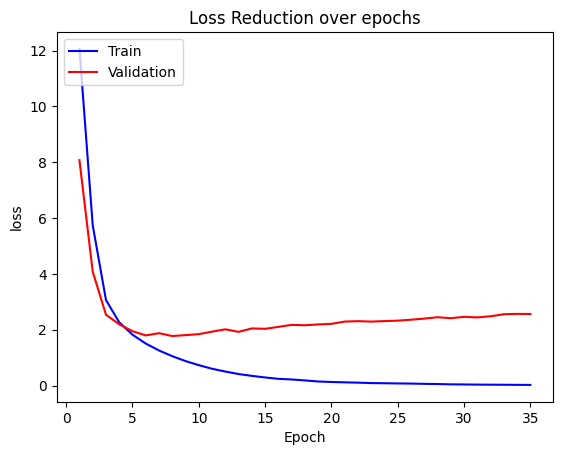

In [ ]:
plotgraph(epoch_range, loss, val_loss, 'Loss Reduction over epochs', 'loss')

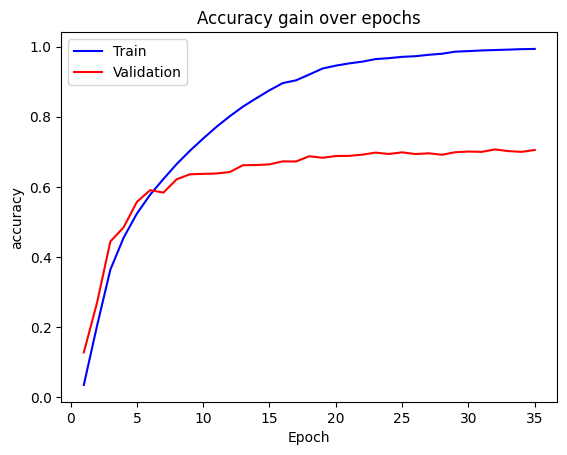

In [ ]:
plotgraph(epoch_range, accuracy, val_accuracy, 'Accuracy gain over epochs', 'accuracy')

Based on the depicted plots, it's noticeable that the model starts exhibiting signs of overfitting at an approximate accuracy of 0.67. The strategy of saving the best weights during each epoch has proven advantageous. Consequently, we will proceed by utilizing the model weights corresponding to the best performance, effectively mitigating the overfitting concern.

# **Model Evaluation**
With the model successfully trained on a dataset of 76,478 images, the focus now shifts to testing its performance. When it comes to testing, our training model isn't applicable due to its reliance on input labels - something unavailable during testing. Thus, to evaluate the model, we'll employ the "crnn_model" we constructed earlier, which exclusively requires the input of test images.

Given that our model generates probability distributions for each class at every time step, a transcription function is necessary to convert these probabilities into meaningful text. To achieve this, we utilized the CTC decoder, a method adept at transforming these predictions into coherent output text.

For assessing accuracy, we utilize the Jaro Distance and Ratio method. This approach quantifies the similarity between strings, providing valuable insights into the model's performance. To implement this method, we utilize the Levenshtein package, which facilitates the calculation of the Jaro distance and ratio. This measurement process offers a robust evaluation of the model's capability in addressing the task at hand.

In [ ]:
from keras.models import load_model

saved_model = load_model("full_model.h5")

In [ ]:
preds = saved_model.predict(test_images)

decoded = K.ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1], greedy=True)[0][0]
predicted_labels = K.get_value(decoded)

202/202 [==============================] - 5s 16ms/step


In [ ]:
!pip install python-levenshtein

**Jaro Distance & Jaro Ratio**

The Jaro Distance and Ratio are string similarity metrics that quantify the degree of similarity between two strings. These metrics consider both the characters present and their order in the strings. The Jaro Distance measures the dissimilarity between strings, with higher values indicating greater similarity. The Jaro Ratio, on the other hand, is obtained by dividing the Jaro Distance by a scaling factor, resulting in a value between 0 and 1, where 1 signifies an exact match.

In [ ]:
import Levenshtein as lv

total_jaro = 0
total_ratio = 0
test_predicted_words = []

for i, x in enumerate(predicted_labels):
    actual_word = test_original_text[i]
    predicted_word = ''
    for p in x:
        if int(p) != -1:
            predicted_word += char_list[int(p)]
    test_predicted_words.append(predicted_word)
    total_jaro += lv.jaro(predicted_word, actual_word)
    total_ratio += lv.ratio(predicted_word, actual_word)

jaro_distance = total_jaro/len(predicted_labels)
jaro_ratio = total_ratio/len(predicted_labels)

print(f'Jaro Distance : {round(jaro_distance * 100, 2)}%')
print(f'Jaro ratio : {round(jaro_ratio * 100, 2)}%')

Jaro Distance : 94.12%
Jaro ratio : 92.55%


**Printing some test images along with their actual and predicted text**

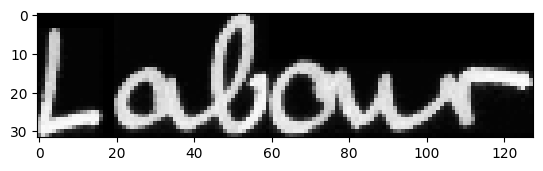

original_text =   Labour
predicted text =  Labour 



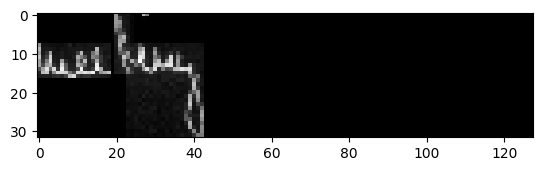

original_text =   meeting
predicted text =  neting 



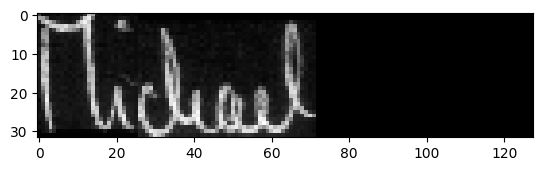

original_text =   Michael
predicted text =  Michal 



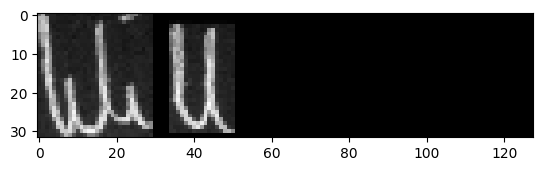

original_text =   Will
predicted text =  Whill 



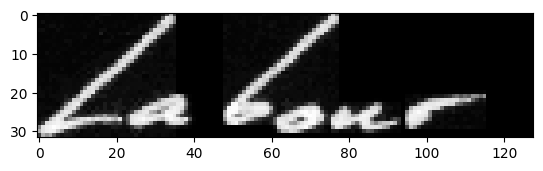

original_text =   Labour
predicted text =  Labour 



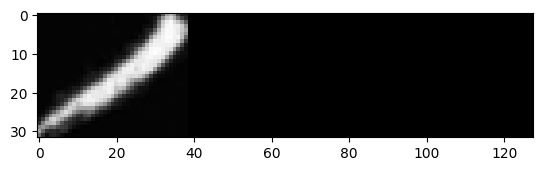

original_text =   ,
predicted text =  , 



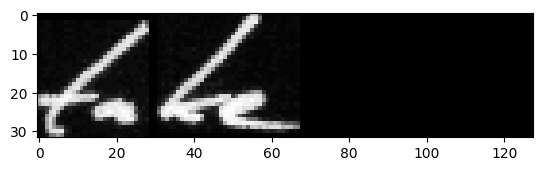

original_text =   take
predicted text =  tabe 



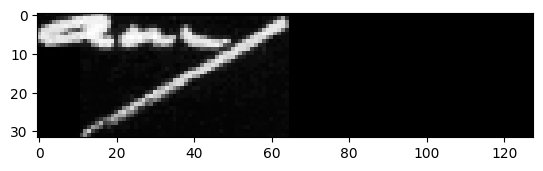

original_text =   any
predicted text =  ayy 



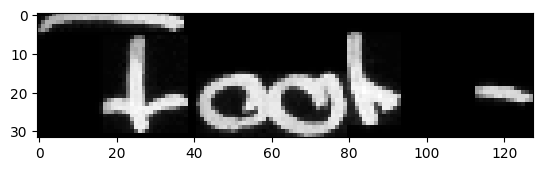

original_text =   Foot-
predicted text =  Foot- 



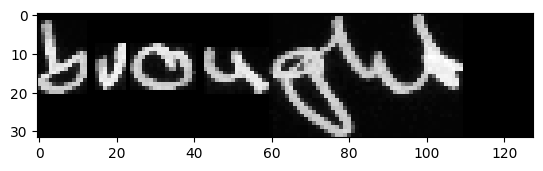

original_text =   brought
predicted text =  brought 



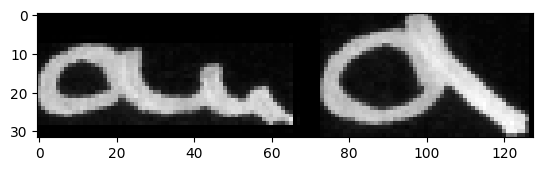

original_text =   and
predicted text =  and 



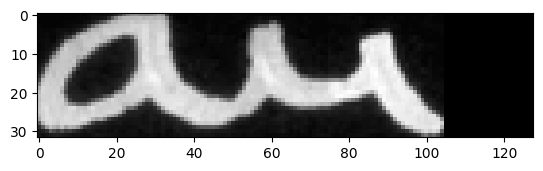

original_text =   an
predicted text =  an 



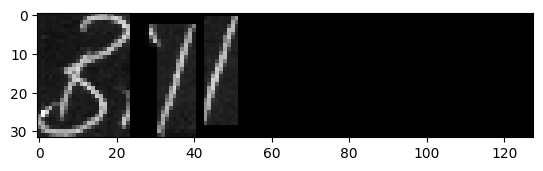

original_text =   Bill
predicted text =  Bll 



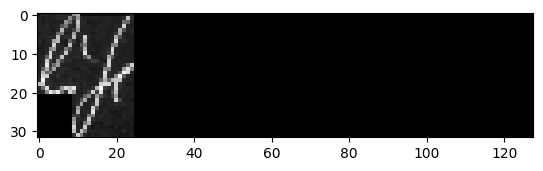

original_text =   life
predicted text =  life 



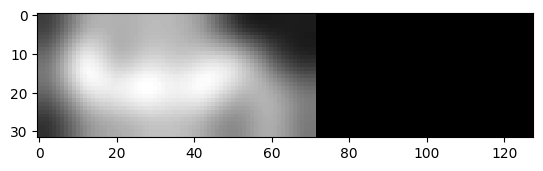

original_text =   .
predicted text =  . 



In [ ]:
for i in range(15):
    plt.imshow(test_images[i], cmap=plt.cm.gray)
    plt.show()
    print("original_text =  ", test_original_text[i])
    print("predicted text = ", test_predicted_words[i], "\n")

# **Exporting the model**

The complete model, in the form of an "h5" file, is stored on Google Drive for the purpose of deployment using Streamlit. To ensure accurate label decoding and word retrieval, the character encoding is also preserved. This encoding information is essential for translating the model's predictions back into meaningful words.

In [ ]:
with open("character_encoding.json", "w") as json_file:
    json.dump(char_list, json_file)
json_file.close()

!cp "full_model.h5" "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/full_model.h5"
!cp "character_encoding.json" "/content/drive/MyDrive/TCSion RIO/Handwritten text extraction/character_encoding.json"